# backbone code 

Reloading graph to ensure lyrics are present...
Debug Check - Node: Missy_Elliott
Debug Check - Has Lyrics? True
Running on: cpu
Gathering lyrics...
Nodes sent to AI: 983
Encoding...


Batches: 100%|██████████| 31/31 [00:42<00:00,  1.36s/it]


Comparing edges...


100%|██████████| 16333/16333 [00:04<00:00, 3355.41it/s]


✨ Pearson Correlation: 0.1642


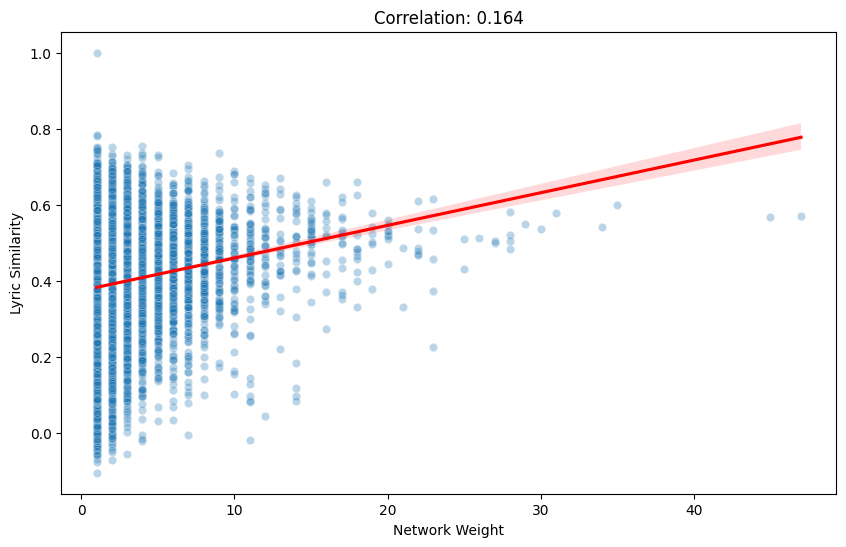

In [6]:
import networkx as nx
from pathlib import Path
import torch
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# --- 1. RELOAD DATA (To ensure we have lyrics) ---
# Update this path if needed
G_path = Path(r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Project\MUSIC\artist_network_NCbackbone_3.graphml")

print("Reloading graph to ensure lyrics are present...")
G = nx.read_graphml(str(G_path))

# # --- 2. CREATE A CORRECT TEST SLICE ---
# # We take the first 200 nodes, but use .subgraph() to KEEP the lyrics
# print("Creating a small test graph (preserving attributes)...")
# test_nodes = list(G_full.nodes())[:200]
# G = G_full.subgraph(test_nodes).copy()

# Check one node to be 100% sure
first_node = list(G.nodes())[0]
print(f"Debug Check - Node: {first_node}")
print(f"Debug Check - Has Lyrics? {'lyrics' in G.nodes[first_node]}")

# --- 3. SETUP AI ---
def get_device():
    if torch.cuda.is_available(): return "cuda"
    if torch.backends.mps.is_available(): return "mps"
    return "cpu"

device = get_device()
print(f"Running on: {device}")
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

# --- 4. PREPARE LYRICS ---
node_ids = []
lyrics_list = []

print("Gathering lyrics...")
for node in G.nodes():
    # Fetch lyrics, convert to string safely
    raw_text = str(G.nodes[node].get('lyrics', ''))
    
    # Check length (str(None) is 4 chars, so >5 filters out empty/None)
    if len(raw_text) > 5:
        node_ids.append(node)
        lyrics_list.append(raw_text[:2000])

print(f"Nodes sent to AI: {len(node_ids)}")

if len(node_ids) == 0:
    raise ValueError("Still no lyrics! Check the 'Debug Check' print above.")

# --- 5. ENCODE & ANALYZE ---
print("Encoding...")
embeddings = model.encode(lyrics_list, show_progress_bar=True, device=device)
embedding_dict = {node: emb for node, emb in zip(node_ids, embeddings)}

print("Comparing edges...")
data_points = []

for u, v, data in tqdm(G.edges(data=True)):
    if u in embedding_dict and v in embedding_dict:
        sim = cosine_similarity([embedding_dict[u]], [embedding_dict[v]])[0][0]
        
        data_points.append({
            'Network Weight': data['weight'], 
            'Lyric Similarity': sim
        })

# --- 6. PLOT ---
df = pd.DataFrame(data_points)

if not df.empty:
    corr = df['Network Weight'].corr(df['Lyric Similarity'])
    print(f"✨ Pearson Correlation: {corr:.4f}")

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Network Weight', y='Lyric Similarity', alpha=0.3)
    sns.regplot(data=df, x='Network Weight', y='Lyric Similarity', scatter=False, color='red')
    plt.title(f"Correlation: {corr:.3f}")
    plt.show()
else:
    print("Not enough edges in this small test slice to plot.")

In [7]:
# --- REBUILD DATAFRAME WITH NAMES ---
print("Re-building dataframe with artist names...")
data_points = []

# Re-run just the comparison loop (very fast, no AI involved)
for u, v, data in tqdm(G.edges(data=True)):
    if u in embedding_dict and v in embedding_dict:
        # We assume cosine_similarity is imported
        # If you get an error, re-import sklearn
        from sklearn.metrics.pairwise import cosine_similarity
        
        sim = cosine_similarity(
            [embedding_dict[u]], 
            [embedding_dict[v]]
        )[0][0]
        
        data_points.append({
            'Artist A': u,
            'Artist B': v,  # <--- Adding names back in!
            'Network Weight': data['weight'], 
            'Lyric Similarity': sim
        })

df = pd.DataFrame(data_points)

# --- NOW FIND THE COUPLES ---
weirdest_pair = df[df['Network Weight'] > 4].sort_values('Lyric Similarity').head(1)
best_match = df[df['Network Weight'] > 4].sort_values('Lyric Similarity', ascending=False).head(1)

print("\n--- THE WEIRDEST COUPLE (High Co-occurrence, Different Lyrics) ---")
print(weirdest_pair[['Artist A', 'Artist B', 'Network Weight', 'Lyric Similarity']].to_string(index=False))

print("\n--- THE PERFECT MATCH (High Co-occurrence, Similar Lyrics) ---")
print(best_match[['Artist A', 'Artist B', 'Network Weight', 'Lyric Similarity']].to_string(index=False))

Re-building dataframe with artist names...


100%|██████████| 16333/16333 [00:04<00:00, 3338.00it/s]


--- THE WEIRDEST COUPLE (High Co-occurrence, Different Lyrics) ---
  Artist A      Artist B  Network Weight  Lyric Similarity
Bruno_Mars Calvin_Harris              11         -0.019096

--- THE PERFECT MATCH (High Co-occurrence, Similar Lyrics) ---
 Artist A   Artist B  Network Weight  Lyric Similarity
Meek_Mill Young_Thug               9          0.736827


# Sentiment

In [8]:
import community.community_louvain as community_louvain 
import networkx as nx
import pandas as pd
from pathlib import Path
from tqdm import tqdm # Import tqdm for progress bar
import matplotlib.pyplot as plt # Keep imports at the top
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# 1. SETUP VADER
try:
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon')
    
sia = SentimentIntensityAnalyzer()

# 2. GET COMMUNITIES (Loading the graph)
G_path = Path(r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Project\MUSIC\artist_network_NCbackbone_3.graphml")

print("Loading graph...")
# Rename to G for general use
G = nx.read_graphml(str(G_path)) 

# --- Community detection and filtering (optional for sentiment calculation, but kept for context) ---
print("Detecting communities (Louvain)...")
partition = community_louvain.best_partition(G, weight='weight')
from collections import Counter
counts = Counter(partition.values())
# Using a dummy list of all communities if we want to process ALL nodes, 
# or keep the big_communities filter if you only want to process a subset.
big_communities = [c for c, count in counts.items() if count > 50]
# -------------------------------------------------------------------------------------------------

# 3. CALCULATE SENTIMENT PER ARTIST AND ADD TO GRAPH
print("Analyzing sentiment and adding it to the graph...")

# Use G.nodes() for all nodes if you want to ensure every node gets the attribute
# If an artist is not in a big community or has no lyrics, their score will be 0 or NaN
for node in tqdm(G.nodes()):
    
    # Optional: Filter by community (remove if you want to process all nodes)
    comm_id = partition.get(node)
    if comm_id not in big_communities:
         # Skip nodes in small communities
         # We still need to set the attribute for all nodes if we want a clean graph save later
         G.nodes[node]['sentiment_compound'] = 0.0 # Assign neutral score or choose to set it to None/NaN
         continue
        
    # Get Lyrics
    text = str(G.nodes[node].get('lyrics', ''))
    
    # If we have lyrics, score them
    if len(text) > 50:
        score = sia.polarity_scores(text)['compound']
        
        # --- KEY STEP: Add the sentiment score as a new node attribute ---
        G.nodes[node]['sentiment_compound'] = score
        
    else:
        # Assign a neutral score or 0 if lyrics are missing or too short
        G.nodes[node]['sentiment_compound'] = 0.0
        
# --------------------------------------------------------------------------
# --- NEW STEP: SAVE THE MODIFIED GRAPH ---
# --------------------------------------------------------------------------

# Define the path for the new GraphML file
new_graph_path = G_path.parent / "artist_network_with_sentiment.graphml"

print(f"Saving new graph with sentiment attributes to: {new_graph_path}")

# Write the graph (which now includes the 'sentiment_compound' attribute on each node)
nx.write_graphml(G, str(new_graph_path))

print("Saving complete.")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Madsl\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Loading graph...
Detecting communities (Louvain)...
Analyzing sentiment and adding it to the graph...


100%|██████████| 1004/1004 [13:50<00:00,  1.21it/s] 


Saving new graph with sentiment attributes to: C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Project\MUSIC\artist_network_with_sentiment.graphml
Saving complete.


Loading graph with pre-calculated sentiment...
Detecting communities (Louvain)...
Found 9 communities. Analyzing 6 major ones.
Extracting sentiment data...


100%|██████████| 1004/1004 [00:00<00:00, 409200.39it/s]
C:\Users\Madsl\AppData\Local\Temp\ipykernel_23696\542258568.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Community', y='Sentiment', data=df_sentiment, order=order, palette="vlag")


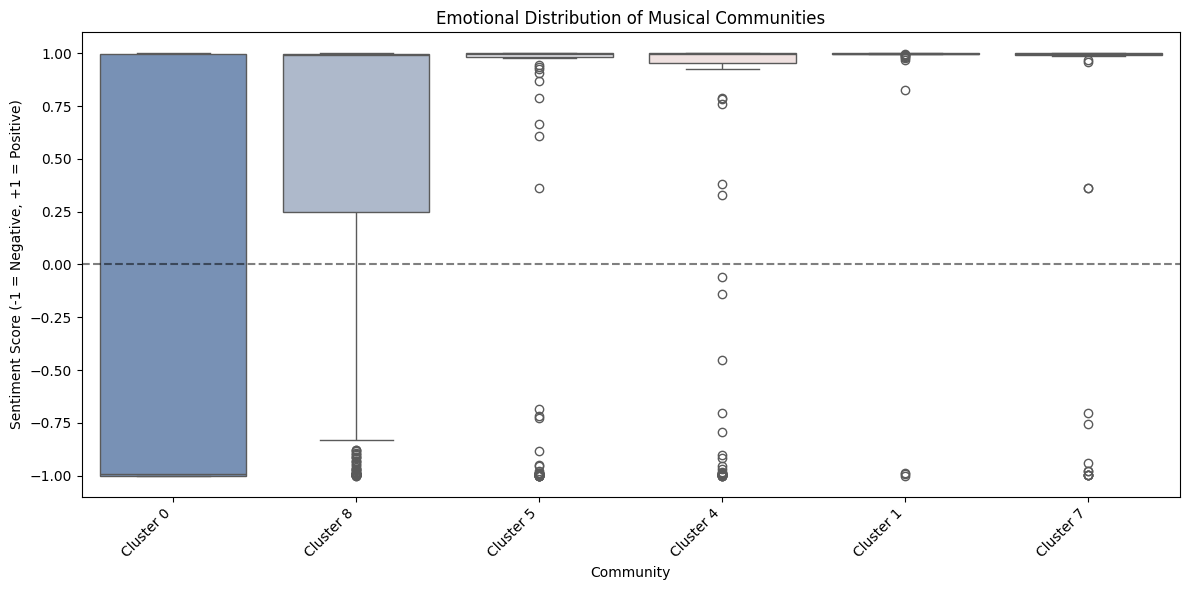


--- COMMUNITY EMOTIONAL PROFILES ---
           count      mean       std
Community                           
Cluster 0  130.0 -0.185328  0.973629
Cluster 8  321.0  0.505683  0.825516
Cluster 5  184.0  0.624263  0.762183
Cluster 4  145.0  0.632423  0.739326
Cluster 7   61.0  0.659833  0.722674
Cluster 1   62.0  0.898742  0.430701


In [21]:
import community.community_louvain as community_louvain 
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm # Import tqdm for progress bar
from collections import Counter

# --- 1. Load the graph with pre-calculated sentiment ---
G_path = Path(r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Project\MUSIC\artist_network_with_sentiment.graphml")

print("Loading graph with pre-calculated sentiment...")
G = nx.read_graphml(str(G_path)) 

# --- 2. Recalculate Communities and Filter ---
# We still need the community partition to group the artists for the box plot.
# Note: You can save the partition too, but recalculating is often simpler.
print("Detecting communities (Louvain)...")
partition = community_louvain.best_partition(G, weight='weight', random_state=5)

# Count how many artists in each community to filter out tiny ones
counts = Counter(partition.values())
# Keep only communities with at least 50 artists
big_communities = [c for c, count in counts.items() if count > 50]

print(f"Found {len(counts)} communities. Analyzing {len(big_communities)} major ones.")

# --- 3. Extract Data for Plotting ---
data = []

print("Extracting sentiment data...")
# Iterate over all nodes
for node in tqdm(G.nodes()):
    comm_id = partition.get(node)
    
    # Only process if node is in a big community
    if comm_id in big_communities:
        
        # --- KEY STEP: Retrieve the saved attribute ---
        # Note: networkx might load the attribute as a string, so we convert it to float
        sentiment_str = G.nodes[node].get('sentiment_compound')
        
        # Skip if the attribute is somehow missing or not a valid number (shouldn't happen if saved correctly)
        try:
            score = float(sentiment_str)
        except (TypeError, ValueError):
            continue 
            
        # Only add data points with a non-zero sentiment (optional, to remove the 0.0 placeholders)
        if score != 0.0:
            data.append({
                'Artist': node,
                'Community': f"Cluster {comm_id}",
                'Sentiment': score
            })

df_sentiment = pd.DataFrame(data)

if df_sentiment.empty:
    print("No relevant sentiment data found after filtering.")
else:
    # --- 4. Sort Communities by Median Sentiment ---
    order = df_sentiment.groupby('Community')['Sentiment'].median().sort_values().index

    # --- 5. VISUALIZE ---
    plt.figure(figsize=(12, 6))
    
    # Using 'vlag' palette for a nice blue-red gradient or 'RdBu' as in the original
    sns.boxplot(x='Community', y='Sentiment', data=df_sentiment, order=order, palette="vlag") 
    
    plt.title("Emotional Distribution of Musical Communities")
    plt.ylabel("Sentiment Score (-1 = Negative, +1 = Positive)")
    plt.xticks(rotation=45, ha='right') # Rotate and align for better readability
    plt.tight_layout() # Adjust plot to prevent labels from being cut off
    plt.axhline(0, color='black', linestyle='--', alpha=0.5) # The "Neutral" line
    plt.show()

    # --- 6. PRINT SUMMARY ---
    print("\n--- COMMUNITY EMOTIONAL PROFILES ---")
    stats = df_sentiment.groupby('Community')['Sentiment'].describe()[['count', 'mean', 'std']]
    print(stats.sort_values(by='mean'))

    # Create a dictionary to store lists of artists per cluster
cluster_members = {}
for node, comm_id in partition.items():
    if comm_id not in cluster_members:
        cluster_members[comm_id] = []
    cluster_members[comm_id].append(node)

# Function to get the most "central" artists in a cluster (highest degree)
def get_top_artists(comm_id, limit=5):
    nodes = cluster_members[comm_id]
    # Sort by degree (popularity in network)
    sorted_nodes = sorted(nodes, key=lambda n: G.degree(n), reverse=True)
    return sorted_nodes[:limit]



In [22]:
print("--- CLUSTER IDENTIFICATION ---")

# Check the Negative One
print(f"\nCluster 0 (The Negative One): {get_top_artists(0)}")

# Check the Mainstream One
print(f"\nCluster 8 (The Big One): {get_top_artists(8)}")

# Check the Happy One
print(f"\nCluster 1 (The Happy One): {get_top_artists(1)}")

--- CLUSTER IDENTIFICATION ---

Cluster 0 (The Negative One): ['Chance_The_Rapper', 'Skrillex', 'The_Offspring', 'Kid_Cudi', 'Childish_Gambino']

Cluster 8 (The Big One): ['Yeah_Yeah_Yeahs', 'Lana_Del_Rey', 'Coldplay', 'The_Shins', 'The_xx']

Cluster 1 (The Happy One): ['Little_Big_Town', 'Alan_Jackson', 'Thompson_Square', 'Blake_Shelton', 'Lady_Antebellum']


Loading graph with pre-calculated sentiment...
Extracting sentiment scores for colors...
Calculating node degree for size...


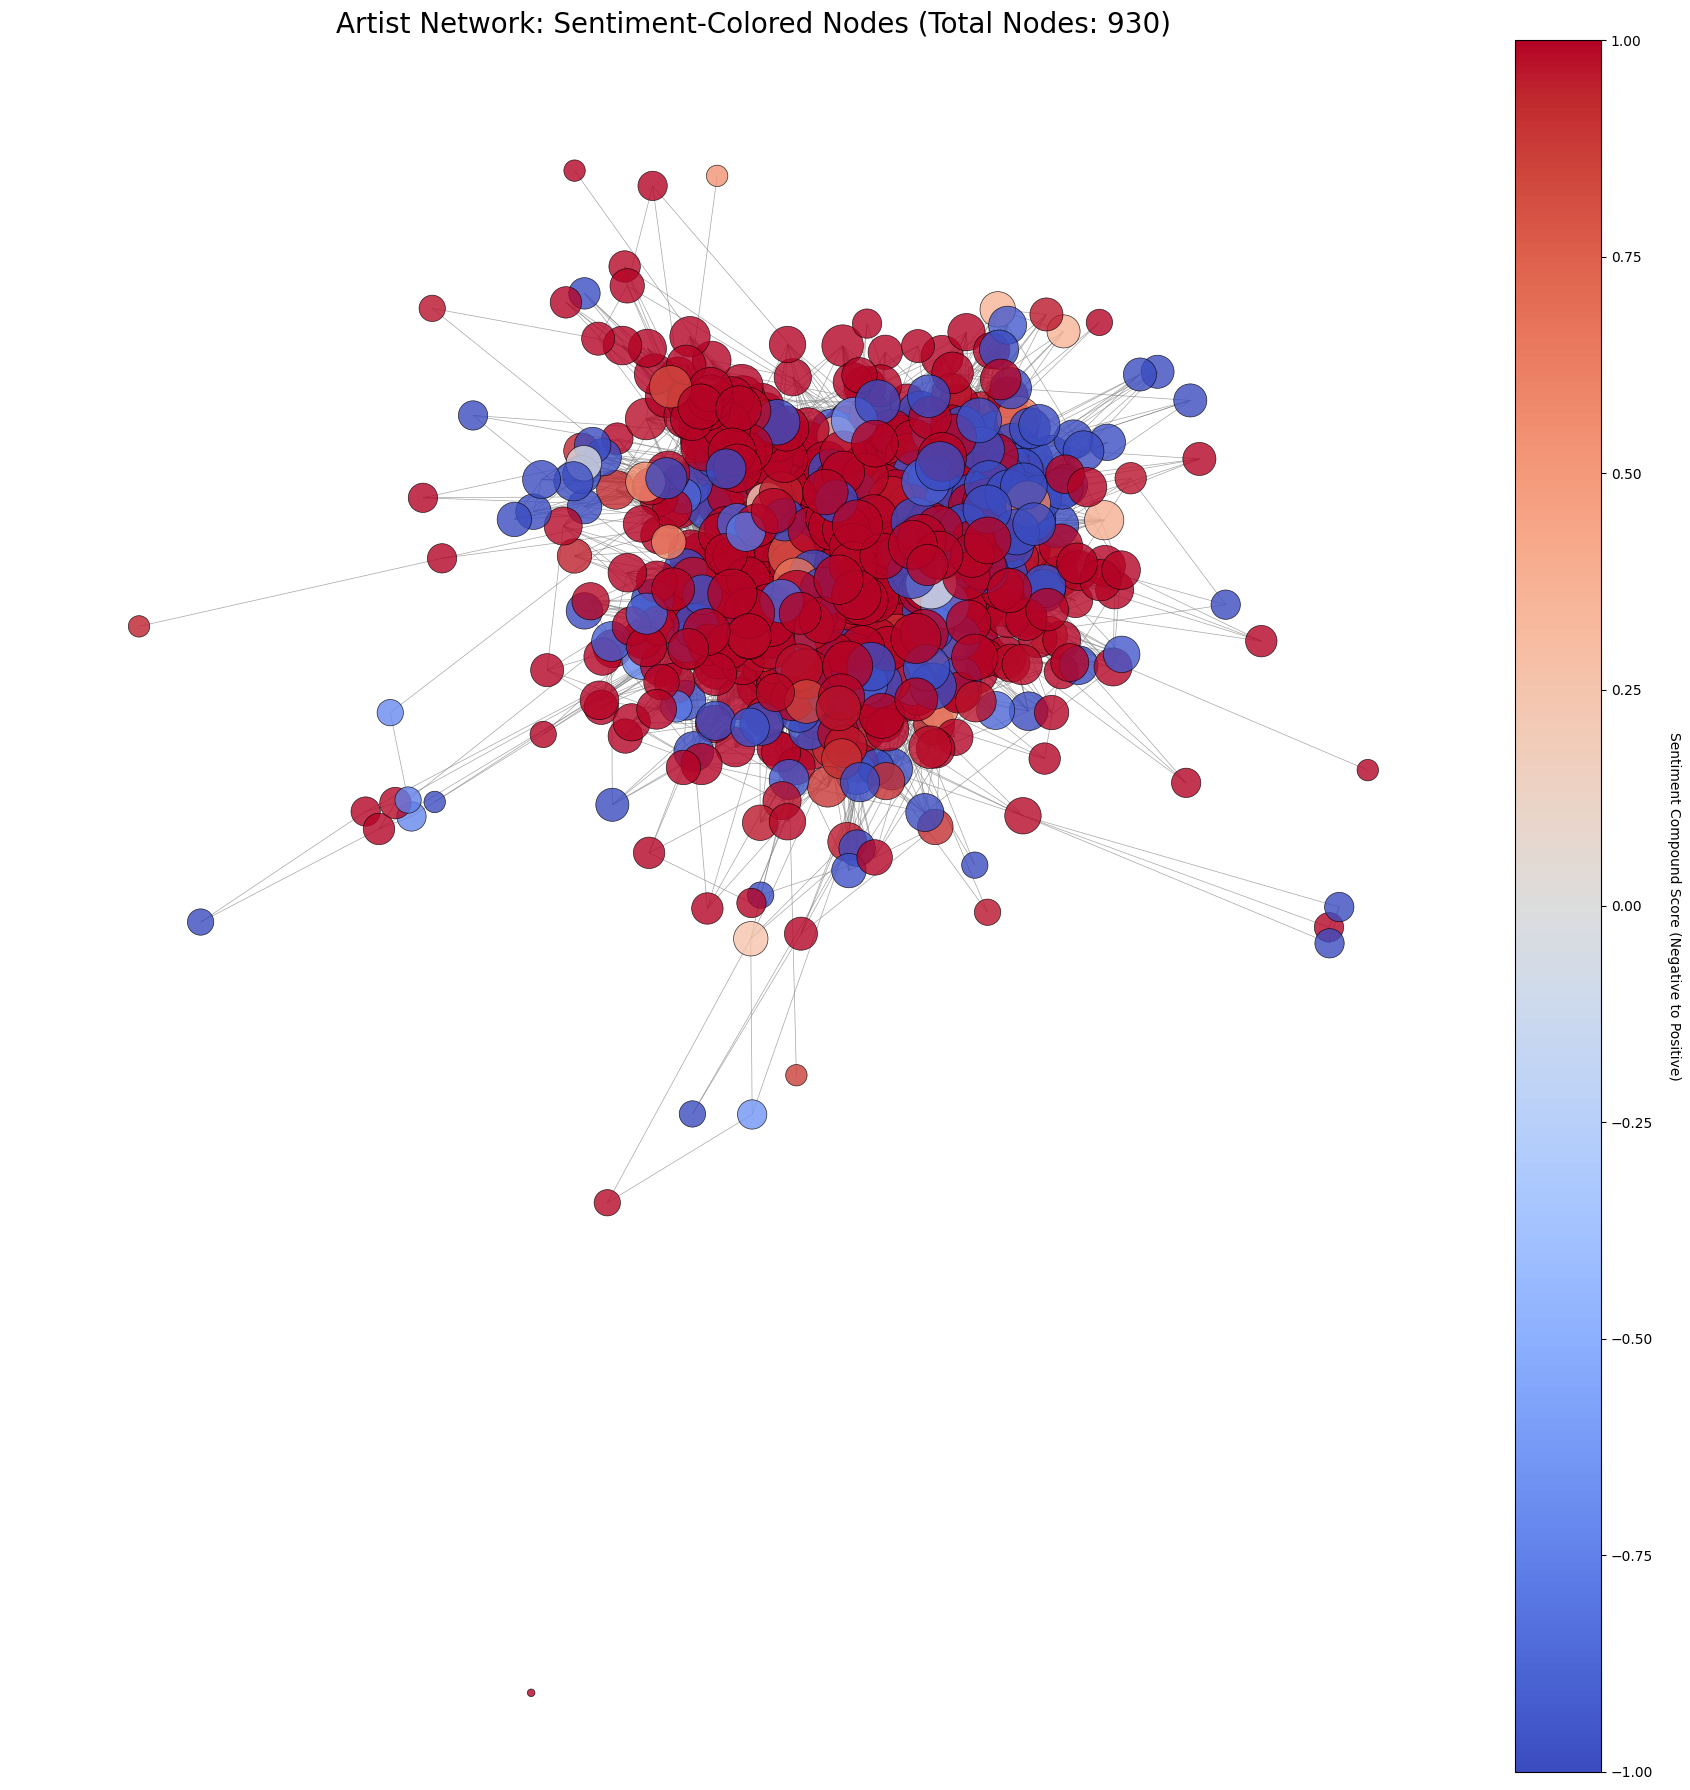

In [23]:
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import community.community_louvain as community_louvain 
from collections import Counter

# --- 1. Load the graph with pre-calculated sentiment ---
G_path = Path(r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Project\MUSIC\artist_network_with_sentiment.graphml")

print("Loading graph with pre-calculated sentiment...")
G = nx.read_graphml(str(G_path)) 

# --- 2. Prepare Node Attributes for Drawing ---

# A. Sentiments for Node Colors
print("Extracting sentiment scores for colors...")
# Get sentiment and convert to float (GraphML often loads numbers as strings)
# We also filter out any nodes where the score might be missing or 0.0 (the placeholders) 
# to keep the visualization focused on scored artists.
sentiment_map = {}
for node, data in G.nodes(data=True):
    try:
        score = float(data.get('sentiment_compound', 0.0))
        # Only include nodes that had actual lyrics (score != 0.0 placeholder)
        if score != 0.0:
            sentiment_map[node] = score
    except (TypeError, ValueError):
        continue

# Create a sub-graph with only the nodes that have a valid sentiment score
nodes_to_draw = list(sentiment_map.keys())
G_sub = G.subgraph(nodes_to_draw).copy()

# Create the list of sentiment scores in the order of the nodes in the subgraph
node_sentiment_colors = [sentiment_map[node] for node in G_sub.nodes()]


# B. Degree for Node Size
print("Calculating node degree for size...")
# Calculate the degree (or weighted degree) of each node
# Use degree for unweighted, or sum of weights for weighted degree
degree_map = dict(G_sub.degree()) 

# Scale the degree values for better visualization (e.g., 50 * log(degree))
# Using log transform helps prevent huge size differences
import numpy as np
base_size = 30 # Minimum size
scaling_factor = 300 # Factor to scale degree by
node_sizes = [
    base_size + scaling_factor * np.log1p(degree_map[node]) 
    for node in G_sub.nodes()
]

# --- 3. Visualize the Network ---

plt.figure(figsize=(18, 18))

# Use the Fruchterman-Reingold (Force-directed) layout for a clustered, organic look
pos = nx.spring_layout(G_sub, k=0.15, iterations=50) # k and iterations control the layout density

# Choose a Colormap that goes from one color (negative) to another (positive)
# 'RdBu_r' is a Red-Blue reversed map (Red=Negative, Blue=Positive)
# 'coolwarm' or 'vlag' are also good for diverging data
cmap = plt.cm.coolwarm 

# Find the global min/max sentiment for the color scale
vmin = -1.0
vmax = 1.0

# Draw the nodes
nodes = nx.draw_networkx_nodes(
    G_sub, 
    pos, 
    node_size=node_sizes, 
    node_color=node_sentiment_colors, 
    cmap=cmap, 
    vmin=vmin, 
    vmax=vmax,
    alpha=0.8,
    linewidths=0.5,
    edgecolors='black'
)

# Draw the edges (light gray/thin)
nx.draw_networkx_edges(
    G_sub, 
    pos, 
    alpha=0.7, 
    width=0.5, 
    edge_color='gray'
)

# --- 4. Add Color Bar (Legend) ---
if nodes is not None:
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([]) # required for older matplotlib versions
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', pad=0.01)
    cbar.set_label('Sentiment Compound Score (Negative to Positive)', rotation=270, labelpad=20)


plt.title(f"Artist Network: Sentiment-Colored Nodes (Total Nodes: {G_sub.number_of_nodes()})", fontsize=20)
plt.axis('off') # Hide the axes
plt.tight_layout()
plt.show()